# IA: Busca de Doadores Compatíveis de Sangue em Hemocentros
Este projeto implementa um protótipo de sistema para **localizar unidades de sangue compatível** disponíveis para doação em uma cidade. A ideia central é permitir que o usuário informe seu tipo sanguíneo e, a partir disso, o sistema identifique o hemocentro mais próximo com estoque suficiente para atendimento, traçando a rota ideal até o local.

O sistema funciona da seguinte maneira:
- Um **grafo da cidade** do usuário é gerado na memória do programa;
- O sistema sabe o **tipo sanguíneo** do usuário e calcula quais são os doadores possíveis;
- De todos os hemocentros da cidade, **filtra** por aqueles que possuem estoque de sangue compatível;
- **Traça a rota** ideal até esse hemocentro.

## Bibliotecas utilizadas

In [1]:
import sys
import os
import osmnx as ox
import matplotlib.pyplot as plt
import contextily as ctx
import pandas as pd

## Modelando o problema

### Gerando um grafo da cidade
Vamos começar gerando o grafo da cidade em que nosso sistema vai rodar. No caso, escolhemos a cidade de São Carlos. 

A classe `Graph` definida em `helper_functions.py` abstrai algumas funcionalidades que iremos precisar mais adiante. Vale ressaltar que existem três formatos de grafo disponíveis e todos eles são abstraídos pela classe Graph, de modo a facilitar o entendimento deste notebook.

1. Utilizamos a biblioteca `osmnx` para gerar e salvar o grafo urbano da cidade em um arquivo .graphml, empregando dados geoespaciais reais do **OpenStreetMap**.
2. Com o próprio `osmnx`, convertemos o grafo para um **GeoDataFrame (GDF)**, formato utilizado exclusivamente para visualização e plotagem sobre mapas reais.
3. Para executar algoritmos de busca e análise de rotas, utilizamos o grafo no formato compatível com a biblioteca `networkx`, facilitando operações algorítmicas.

Vamos começar instanciando o grafo e examinando visualmente seus nós e arestas.

In [2]:
# Nome da cidade
cidade = "São Carlos, São Paulo, Brasil"

# Baixa o grafo das ruas para transporte por carro (modo drive)
G = ox.graph_from_place(cidade, network_type='drive')
ox.save_graphml(G, filepath="../data/sao_carlos.graphml")

Número de nós: 9042
Número de arestas: 22340


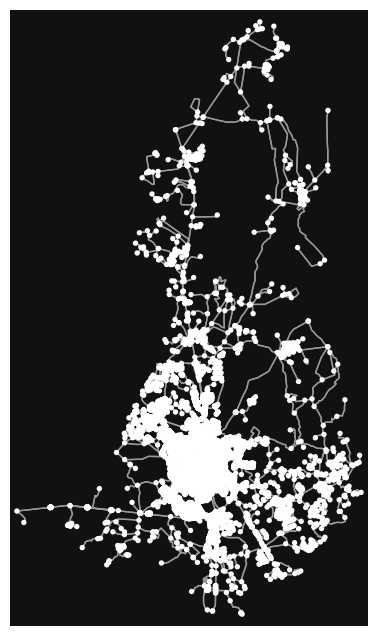

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [3]:
sys.path.append(os.path.abspath('../src'))

from utils.helper_functions import Graph

# Instanciando a classe Graph
G = Graph("../data/sao_carlos.graphml")

# Mostra informações do grafo
print(f"Número de nós: {len(G.graph.nodes)}")
print(f"Número de arestas: {len(G.graph.edges)}")

# Desenha o grafo
ox.plot_graph(G.graph)

Essa é a carinha do nosso grafo. Para visualizá-lo melhor, vamos colocar essa rede em cima do mapa real de São Carlos.

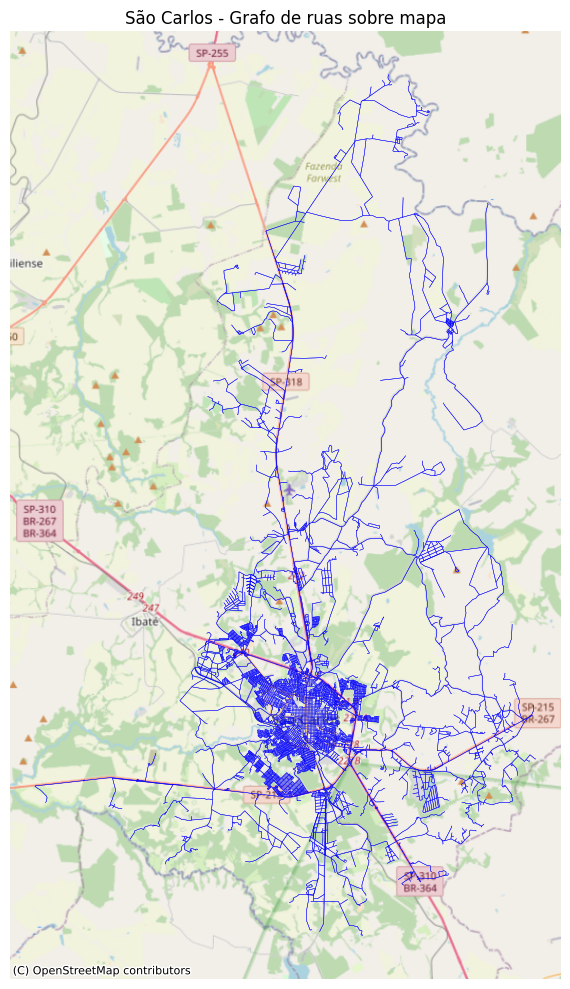

In [4]:
# Plotando as ruas de São Carlos sobre o mapa da cidade
edges = G.edges_gdf

fig, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, linewidth=0.3, edgecolor="blue")
ctx.add_basemap(ax, crs=edges.crs, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

plt.title("São Carlos - Grafo de ruas sobre mapa")
plt.tight_layout()

plt.savefig("../images/sao_carlos_mapa.png", dpi=300)

plt.show()

### Definindo os Hemocentros
Agora que já possuímos o grafo da cidade toda de São Carlos, devemos definir onde ficarão os `Hemocentros`, que são os nós de interesse do nosso problema de busca (nós finais). Para isso, vamos simplesmente escolher 5 nós aleatórios para representar os Hemocentros. Na classe `Graph` já existe um método implementado que retorna n nós aleatórios do grafo, o método `G.get_random_nodes(int n)`.

Cada nó do grafo é salvo com um ID, isto é, uma String que o identifica. Logo, essa função justamente sorteia n dentre todos os IDs aleatórios, armazenados no atributo `G.graph.nodes`.

In [5]:
# Pegando 5 nós aleatórios para representar os hemocentros
hemocentros = G.get_random_nodes(5)
print(hemocentros)

[2104406877, 5025460533, 570173912, 1013705004, 7809785199]


Vamos semelhantemente ao caso anterior plotar os hemocentros sobre o mapa de São Carlos, a fim de obter uma melhor visualização dos nossos dados. Os círculos vermelhos no mapa representarão a localização dos hemocentros.

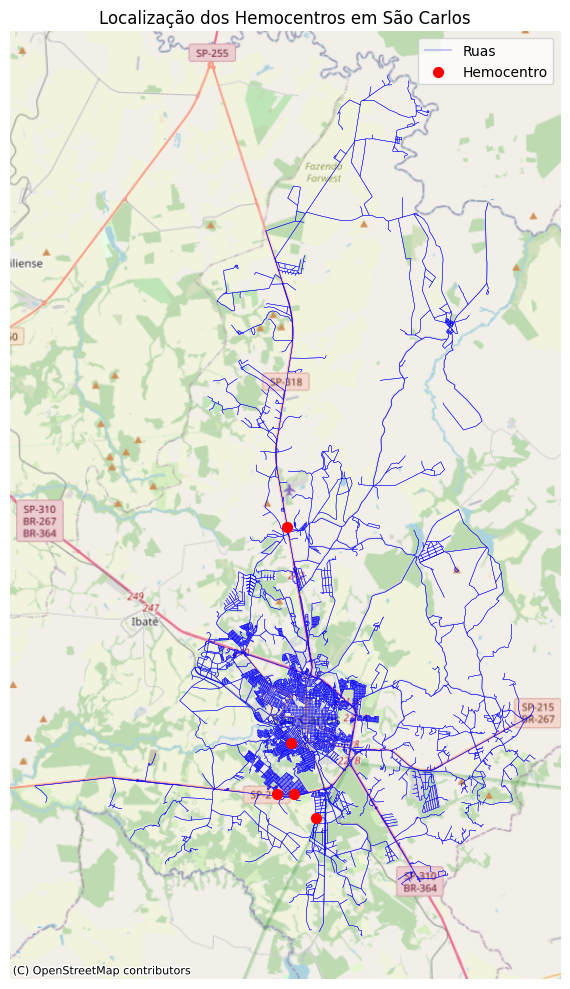

In [6]:
# Converte os hemocentros para GDF (somente para poder plotar)
gdf_hemocentros = G.get_gdf_nodes(hemocentros)

# Plotando o mapa
fig, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, linewidth=0.3, edgecolor="blue", label='Ruas')
gdf_hemocentros.plot(ax=ax, color="red", markersize=50, zorder=3, label='Hemocentro')

ctx.add_basemap(ax, crs=edges.crs, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

plt.legend()
plt.title("Localização dos Hemocentros em São Carlos")
plt.tight_layout()

plt.savefig("../images/hemocentros.png", dpi=300)

plt.show()

Precisamos ainda definir o estoque de determinado tipo sanguíneo em cada um dos hemocentros. Para isso, vamos usar uma outra classe definida em `helper_functions.py`, a classe `BancoDeHemocentros`. Essa classe abstrai todo o estoque de bolsas de sangue de todos os hemocentros da cidade de São Carlos (ou de qualquer cidade que utilize o sistema). Logo, nossa variável `H` será a representande de todo o banco de dados dos hemocentros da cidade em questão.

In [7]:
from utils.helper_functions import BancoDeHemocentros

# Instanciando o banco de hemocentros
H = BancoDeHemocentros(hemocentros, G.graph)

# Exemplo, estoque de bolsas de sangue um único hemocentro
H.consultar_estoque(hemocentros[0])

{'A+': 0, 'A-': 18, 'B+': 0, 'B-': 0, 'AB+': 0, 'AB-': 2, 'O+': 0, 'O-': 0}

### Localização do Usuário
Agora, que temos os hemocentros dipostos aleatoriamente, precisamos definir a localização do nó inicial, ou seja, da localização atual do usuário do sistema. Vamos também gerar uma localização aleatória para representar o ponto de partida do grafo.

In [8]:
user = G.get_random_nodes(1)
print(user)

[4306890563]


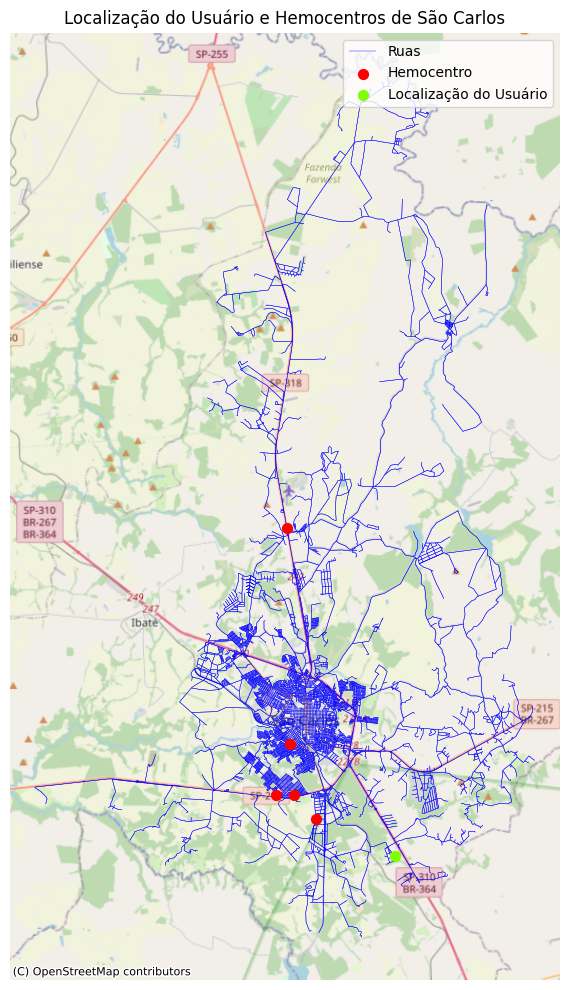

In [9]:
# Converte o ID em GDF (para plotar)
gdf_user = G.get_gdf_nodes(user)

# Plotando o mapa com a localização aleatória
fig, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, linewidth=0.3, edgecolor="blue", label='Ruas')
gdf_hemocentros.plot(ax=ax, color="red", markersize=50, zorder=3, label='Hemocentro')
gdf_user.plot(ax=ax, color="chartreuse", markersize=50, zorder=3, label='Localização do Usuário')

ctx.add_basemap(ax, crs=edges.crs, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

plt.legend()
plt.title("Localização do Usuário e Hemocentros de São Carlos")
plt.tight_layout()

plt.savefig("../images/usuario.png", dpi=300)

plt.show()

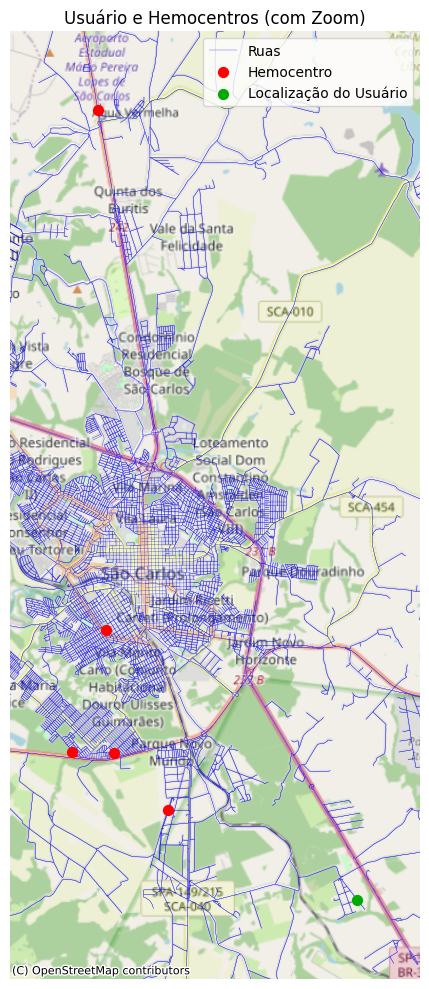

In [10]:
from utils.helper_functions import plotar_com_zoom
plotar_com_zoom(gdf_user, gdf_hemocentros, edges)

## Buscas: BFS e A*
As duas buscas implementadas para solucionar o problema são a Busca em Largura (ou Breadth-First Search) e o algoritmo A* (A-Estrela). 

Antes de executar as buscas, o sistema deve ser capaz de identificar através do banco de dados quais hemocentros possuem os tipos sanguíneos doadores compatíveis com o do usuário. Assim, deve-se filtrar os hemocentros que não atendem às necessidades antes de realizar a busca.

In [11]:
# Definindo o tipo de sangue do usuário e filtrando os HCs válidos
blood_type = "O-"
hcs_validos = H.hemocentros_validos(blood_type)

print(hcs_validos)

[5025460533, 570173912, 1013705004]


Estes IDs acima são os nós dos hemocentros válidos, isto é, aqueles que possuem estoque de sangue compatível com o usuário para realizar a doação. Perceba que o número de hemocentros válidos é menor ou igual ao número de todos os hemocentros da cidade, pois nem todos eles tem sangue compatível com nosso usuário.

Vamos visualizar (com zoom) a localização dos hemocentros compatíveis, em relação à localização do usuário do sistema.

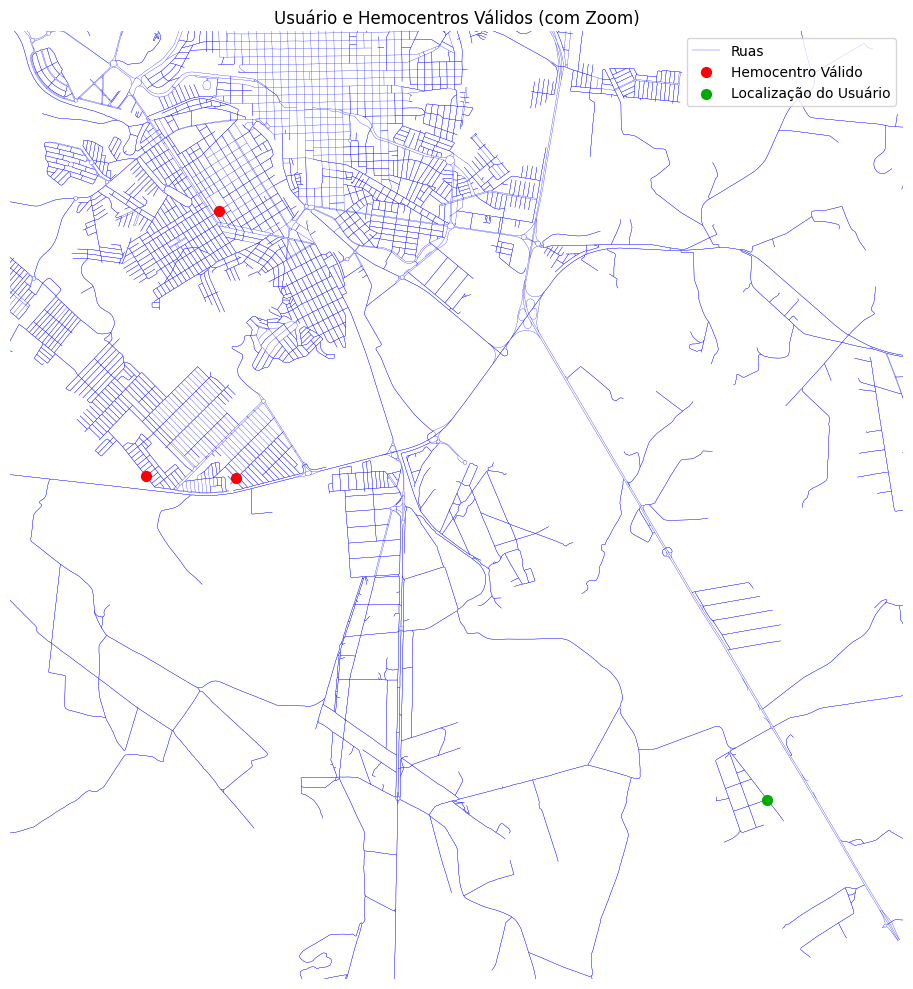

In [12]:
from utils.helper_functions import plotar_com_zoom

# Juntando os pontos que queremos enquadrar
gdf_hcs_validos = G.get_gdf_nodes(hcs_validos)

plotar_com_zoom(gdf_user, gdf_hcs_validos, edges, valid=True, map=False)

Agora que o sistema sabe todas as informações pertinentes, vamos realizar as buscas de fato.

### Busca não informada: BFS (Breadth-First Search)
A Busca em Largura é a mais adequada quando o assunto é salvar vidas. Nesse problema, não estamos interessados em qualquer caminho, e sim no mais curto, ou nos mais curtos. 

No entanto, sabemos que, diferentemente de algoritmos que levam pesos e heurísticas em consideração, no BFS não somos capazes de dizer se de fato estamos percorrendo a menor distância! Isso parece contraintuitivo, mas na verdade é bem nítido.

O BFS encontrará o menor caminho em termos de arestas percorridas, mas isso não necessariamente garantirá que será a menor distância, já que não consideramos o peso das arestas. Considerações nessa estirpe não são resolvidas aqui, mas serão feitas no algoritmo A*.

In [13]:
G.graph.nodes[user[0]]

{'y': -22.1037175, 'x': -47.8304494, 'street_count': 3}

Criamos o arquivo `busca_nao_informada.py`, que contém a implementação da busca em largura, a partir da função `rota_bfs` que irá:

- Receber o grafo (NetworkX)
- Receber um nó de origem
- Receber uma lista de nós de destino (vários hemocentros compatíveis)
- Retornar o primeiro caminho mais curto até algum deles

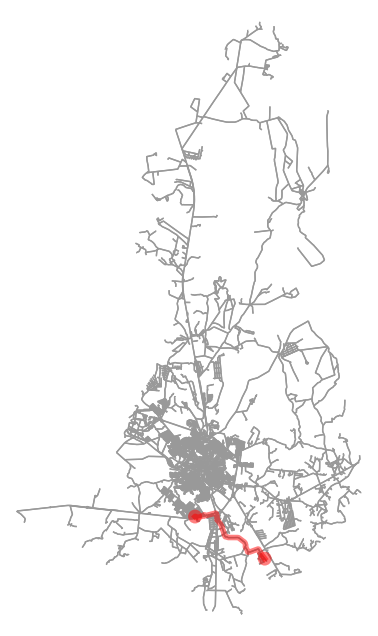

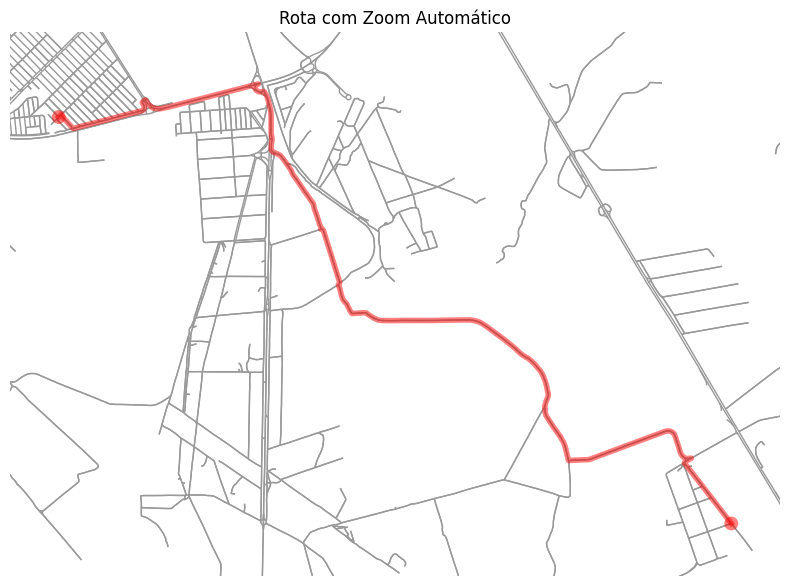

In [14]:
from algorithms.busca_nao_informada import bfs

rota_bfs = bfs(G.graph, user[0], hcs_validos)

if rota_bfs:
    G.plotar_rota(rota_bfs)
    G.plotar_rota_com_zoom(rota_bfs)

else:
    print("Nenhum hemocentro acessível foi encontrado.")

A seguir estamos fazendo uma comparação entre nossa implementação da BFS e o algoritmo padrão da biblioteca networkx, que faz uma busca cuja ponderação é baseada no peso "length", que são as distâncias em metros mesmos fornecidas pelo OSM. A `rota_curta` é de fato a rota mais curta em metros, enquanto `rota_bfs` é a rota mais curta em número de arestas.

In [15]:
import networkx as nx

# Calcula rota ótima com menor distância em metros (já usa weight='length')
rota_curta = G.calcular_rota(user[0], hcs_validos[0])  # usa nx.shortest_path com peso

# Calcula rota BFS (não ponderada, menor número de nós)
from algorithms.busca_nao_informada import bfs
rota_bfs = bfs(G.graph, user[0], hcs_validos)

# Mostra quantos nós foram usados em cada rota
print(f"🔴 Rota BFS: {len(rota_bfs)} nós")
print(f"🟢 Rota com menor distância (curta): {len(rota_curta)} nós")

# Comparando as rotas
# Comparar os caminhos ou distâncias totais percorridas
distancia_curta = G.calcular_distancia(user[0], hcs_validos[0])

distancia_bfs = 0
for i in range(len(rota_bfs) - 1):
    u, v = rota_bfs[i], rota_bfs[i + 1]
    
    # Verifica se a aresta existe no grafo
    if G.graph.has_edge(u, v):
        edge_data = G.graph[u][v]  # Pega os dados da aresta
        # Acessa o comprimento da aresta
        length = edge_data[0].get('length', 0)  # Caso não tenha 'length', assume 0
        distancia_bfs += length
    else:
        print(f"Aresta entre {u} e {v} não encontrada no grafo.")

# Imprime as distâncias totais das rotas
print(f"🔴 Distância total BFS: {distancia_bfs} metros")
print(f"🟢 Distância total da rota curta: {distancia_curta} metros")

# Compara se as rotas são iguais ou diferentes
if rota_bfs == rota_curta:
    print("✅ BFS encontrou a mesma rota da menor distância (coincidência rara).")
else:
    print("⚠️ BFS encontrou uma rota diferente da mais curta em distância — esperado!")

🔴 Rota BFS: 45 nós
🟢 Rota com menor distância (curta): 71 nós
🔴 Distância total BFS: 10876.068628256886 metros
🟢 Distância total da rota curta: 12595.46654908739 metros
⚠️ BFS encontrou uma rota diferente da mais curta em distância — esperado!


Olha que interessante!

O resultado acima mostra que a rota BFS, que encontra a solução que passa por menos arestas (isto é, dá menos saltos) não coincide com a solução que é de fato, mais curta, em termos de distância (em metros mesmo!). Isso era de se esperar e mostra de maneira cabal que essa busca BFS, assim como a DFS (buscas não informadas no geral) não são adequadas para esse problema, que lida com vidas humanas.

### Busca Informada: A* (A-Star)
O algoritmo A* (A-Estrela) de busca em grafos é um tipo de busca informada, no qual utiliza-se de uma heurística para avaliar o quão mais próximo estamos do destino final. Vale ressaltar que a heurística é uma estimativa, que guia a tomada de decisão do algoritmo.

O algoritmo funciona da seguinte forma:


$f(n) = g(n) + h(n)$


- **f(n)**: custo total estimado do caminho passando pelo nó `n`
- **g(n)**: custo real do caminho do início até `n`
- **h(n)**: custo estimado de `n` até o destino (heurística)

Ele percorre o grafo buscando sempre os menores valores de $f(n)$, até que encontre um nó final. No caso de mapas ou grafos espaciais (como ruas), a heurística mais usada é a **distância euclidiana ou geodésica** (haversine) entre os pontos. Esta é justamente a heurística que iremos utilizar!

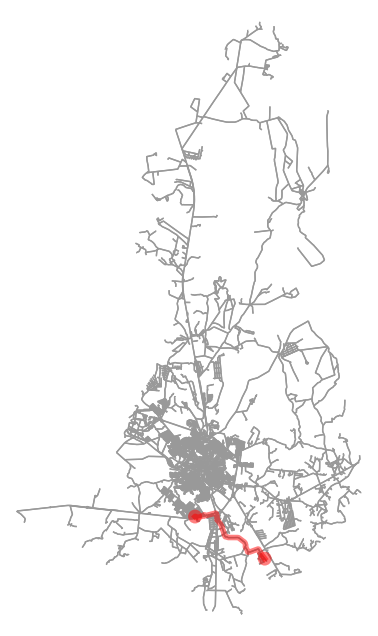

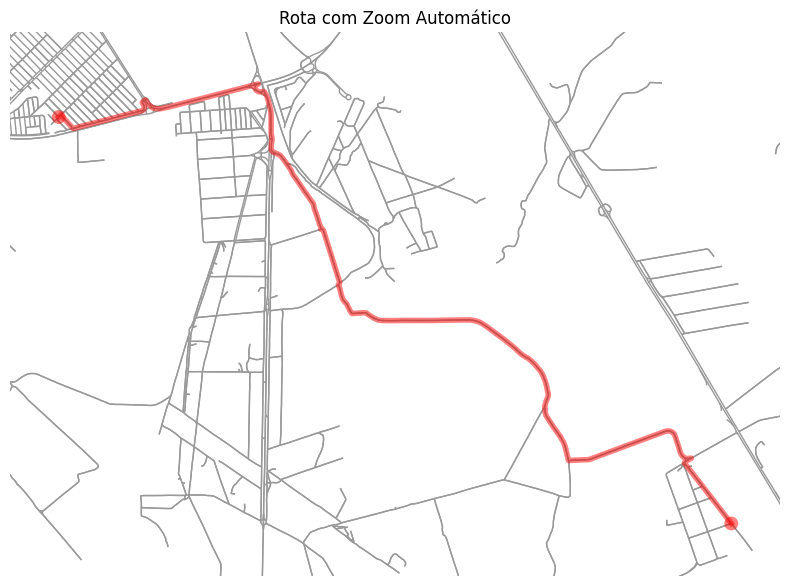

In [16]:
from algorithms.busca_informada import a_estrela

rota_a_estrela = a_estrela(G.graph, user[0], hcs_validos)

if rota_a_estrela:
    G.plotar_rota(rota_a_estrela)
    G.plotar_rota_com_zoom(rota_a_estrela)

else:
    print("Nenhum hemocentro acessível foi encontrado.")

In [17]:
# Calcula rota ótima com menor distância em metros (já usa weight='length')
rota_curta = G.calcular_rota(user[0], hcs_validos[0])  # usa nx.shortest_path com peso 'length'

# Calcula rota A* (também usando uma heurística adequada)
from algorithms.busca_informada import a_estrela
rota_a_estrela = a_estrela(G.graph, user[0], hcs_validos)

# Mostra quantos nós foram usados em cada rota
print(f"🔴 Rota A*: {len(rota_a_estrela)} nós")
print(f"🟢 Rota com menor distância (curta): {len(rota_curta)} nós")

# Comparando as rotas
# Comparar os caminhos ou distâncias totais percorridas
distancia_curta = G.calcular_distancia(user[0], hcs_validos[1])

# Calcula a distância total da rota A* somando o comprimento de cada aresta
distancia_a_estrela = 0
for i in range(len(rota_a_estrela) - 1):
    u, v = rota_a_estrela[i], rota_a_estrela[i + 1]
    
    # Verifica se a aresta existe no grafo
    if G.graph.has_edge(u, v):
        edge_data = G.graph[u][v]  # Pega os dados da aresta
        # Acessa o comprimento da aresta
        length = edge_data[0].get('length', 0)  # Caso não tenha 'length', assume 0
        distancia_a_estrela += length
    else:
        print(f"Aresta entre {u} e {v} não encontrada no grafo.")

# Imprime as distâncias totais das rotas
print(f"🔴 Distância total A*: {distancia_a_estrela} metros")
print(f"🟢 Distância total da rota curta: {distancia_curta} metros")

# Compara se as distâncias totais são iguais ou diferentes
if distancia_a_estrela == distancia_curta:
    print("✅ A* encontrou a mesma rota da menor distância (coincidência rara).")
else:
    print("⚠️ A* encontrou uma rota diferente da mais curta em distância — esperado!")

🔴 Rota A*: 45 nós
🟢 Rota com menor distância (curta): 71 nós
🔴 Distância total A*: 10876.068628256886 metros
🟢 Distância total da rota curta: 12833.97889594125 metros
⚠️ A* encontrou uma rota diferente da mais curta em distância — esperado!
